In this post, we look at AutoPyTorch, a framework for automated machine learning.

In [23]:
import os
import tempfile as tmp
import warnings
import pandas as pd
import numpy as np

import sklearn.datasets
import sklearn.model_selection

os.environ['JOBLIB_TEMP_FOLDER'] = tmp.gettempdir()
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


In [24]:
from autoPyTorch.api.tabular_regression import TabularRegressionTask

In [112]:
X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    random_state=1,
)

# Obtain training and validation data
X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X_train,
    y_train,
    random_state=1,
)


In [113]:
X_train.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
52,-0.052738,-0.044642,-0.009439,-0.005671,0.039710,0.044719,0.026550,-0.002592,-0.018118,-0.013504
121,0.063504,-0.044642,0.017506,0.021872,0.008063,0.021546,-0.036038,0.034309,0.019908,0.011349
170,0.023546,0.050680,-0.020218,-0.036656,-0.013953,-0.015092,0.059685,-0.039493,-0.096433,-0.017646
287,0.045341,-0.044642,-0.006206,-0.015999,0.125019,0.125198,0.019187,0.034309,0.032433,-0.005220
397,0.052606,-0.044642,-0.004050,-0.030918,-0.046975,-0.058307,-0.013948,-0.025840,0.036056,0.023775


In [114]:
y_train.head()

52      59.0
121    173.0
170     47.0
287    219.0
397    198.0
Name: target, dtype: float64

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rf = RandomForestRegressor(random_state=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_rf))

62.77500577100372

In [116]:
pred_df = pd.DataFrame({"rf": y_pred_rf, "true": y_test})
pred_df.head()

,rf,true
246,140.76,78.0
425,109.89,152.0
293,161.93,200.0
31,70.81,59.0
359,150.91,311.0


In [117]:
# Use validation dataset to find best hyperparameters for RF
rf = RandomForestRegressor(random_state=1)
hyperparameters = {"n_estimators": [10, 100, 1000], "max_depth": [1, 5, 10]}

from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(rf, hyperparameters, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(X_valid, y_valid)

grid_search.best_params_



{'max_depth': 5, 'n_estimators': 100}

In [119]:
# Train the RF model using the best hyperparameters on train + validation data

rf = RandomForestRegressor(**grid_search.best_params_, random_state=1)
# Combine train and validation data
X_train_overall = pd.concat([X_train, X_valid])
y_train_overall = pd.concat([y_train, y_valid])
rf.fit(X_train_overall, y_train_overall)
y_pred_rf = rf.predict(X_test)
np.sqrt(mean_squared_error(y_test, y_pred_rf))

61.69476644955032

In [120]:
api = TabularRegressionTask()

# Do an api search without any memory limit but use only MLPs

api.search(
    X_train=X_train_overall,
    y_train=y_train_overall,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    optimize_metric='r2',
    total_walltime_limit=80,
    func_eval_time_limit_secs=10,
    dataset_name="Diabetes",
    memory_limit=None,
    enable_traditional_pipeline=True,
    )

In [121]:
y_pred = api.predict(X_test)
score = api.score(y_pred, y_test)
print(score)
np.sqrt(mean_squared_error(y_test, y_pred))

{'r2': 0.3195282683852355}


59.60580312650306

In [122]:
# Print statistics from search
print(api.sprint_statistics())

autoPyTorch results:
	Dataset name: Diabetes
	Optimisation Metric: r2
	Best validation score: 0.4352600925944532
	Number of target algorithm runs: 17
	Number of successful target algorithm runs: 13
	Number of crashed target algorithm runs: 2
	Number of target algorithms that exceeded the time limit: 2
	Number of target algorithms that exceeded the memory limit: 0



In [123]:
api.get_models_with_weights()[0]

(0.6000000000000001,
 MyTraditionalTabularRegressionPipeline(config='random_forest',
                                        dataset_properties={'categorical_columns': [],
                                                            'categories': [],
                                                            'input_shape': (10,),
                                                            'is_small_preprocess': True,
                                                            'issigned': True,
                                                            'issparse': False,
                                                            'numerical_columns': [0,
                                                                                  1,
                                                                                  2,
                                                                                  3,
                                                                                  

In [124]:
api.get_models_with_weights()[1]

(0.16000000000000003,
 MyTraditionalTabularRegressionPipeline(config='svm',
                                        dataset_properties={'categorical_columns': [],
                                                            'categories': [],
                                                            'input_shape': (10,),
                                                            'is_small_preprocess': True,
                                                            'issigned': True,
                                                            'issparse': False,
                                                            'numerical_columns': [0,
                                                                                  1,
                                                                                  2,
                                                                                  3,
                                                                                  4,
      

In [125]:
api.get_models_with_weights()[2]

(0.12000000000000001,
 ________________________________________
 	TabularRegressionPipeline
 ________________________________________
 0-) imputer: 
 	SimpleImputer
 
 1-) variance_threshold: 
 	VarianceThreshold
 
 2-) coalescer: 
 	NoCoalescer
 
 3-) encoder: 
 	NoEncoder
 
 4-) scaler: 
 	StandardScaler
 
 5-) feature_preprocessor: 
 	NoFeaturePreprocessor
 
 6-) tabular_transformer: 
 	TabularColumnTransformer
 
 7-) preprocessing: 
 	EarlyPreprocessing
 
 8-) network_embedding: 
 	autoPyTorch.pipeline NoEmbedding
 
 9-) network_backbone: 
 	autoPyTorch.pipeline ShapedMLPBackbone
 
 10-) network_head: 
 	autoPyTorch.pipeline FullyConnectedHead
 
 11-) network: 
 	Sequential ({'random_state': RandomState(MT19937) at 0x1A34C2840, '_fit_requirements': [FitRequirement(name='network_head', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defined=False, dataset_property=False), FitRequirement(name='network_backbone', supported_types=(<class 'torch.nn.modules.module.Modul

In [126]:
pred_df["Auto"] = y_pred
pred_df.head()

,rf,true,Auto
246,140.76,78.0,124.306467
425,109.89,152.0,110.260403
293,161.93,200.0,172.827616
31,70.81,59.0,81.760498
359,150.91,311.0,148.077544


In [127]:
pred_df_error = pred_df.copy()
pred_df_error["Auto"] = pred_df_error["Auto"] - pred_df_error["true"]
pred_df_error["rf"] = pred_df_error["rf"] - pred_df_error["true"]

pred_df_error

,rf,true,Auto
246,62.76,78.0,46.306467
425,-42.11,152.0,-41.739597
293,-38.07,200.0,-27.172384
31,11.81,59.0,22.760498
359,-160.09,311.0,-162.922456
...,...,...,...
117,-89.37,281.0,-97.738050
139,-28.84,281.0,-56.402282
218,-77.24,214.0,-75.642767
93,-15.33,96.0,-8.373598


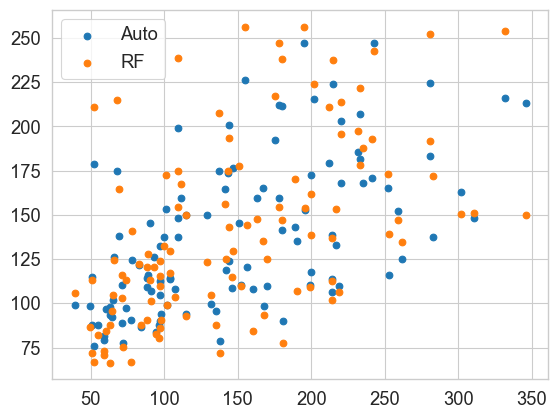

In [128]:
# Scatter plot of the predictions
import matplotlib.pyplot as plt
import seaborn as sns

plt.scatter(pred_df["true"], pred_df["Auto"], label="Auto")
plt.scatter(pred_df["true"], pred_df["rf"], label="RF")
plt.legend()

What if we fit only NNs?

In [129]:
api2 = TabularRegressionTask(seed=2, ensemble_size=0)

api2.search(
    X_train=X_train,
    y_train=y_train,
    X_test=X_test.copy(),
    y_test=y_test.copy(),
    optimize_metric='r2',
    total_walltime_limit=40,
    func_eval_time_limit_secs=10,
    dataset_name="Diabetes",
    memory_limit=None,
    enable_traditional_pipeline=False,
    )


[WARNING] [2023-02-25 11:44:43,866:Client-autoPyTorch.automl_common.common.utils.backend] Directory /var/folders/1x/wmgn24mn1bbd2vgbqlk98tbc0000gn/T/autoPyTorch_tmp_9cde18ea-b4d3-11ed-be1d-3c7d0a00e5d9/.autoPyTorch/ensembles does not exist
[ERROR] [2023-02-25 11:44:43,870:Client-AutoPyTorch:Diabetes:2] No valid ensemble was created. Please check the logfile for errors. Default to the best individual estimator:[(2, 2, 5.555555555555555)]
NoneType: None


In [130]:
y_pred2 = api2.predict(X_test)
score2 = api2.score(y_pred2, y_test)
score2

{'r2': -0.37656772470491995}

In [131]:
np.sqrt(mean_squared_error(y_test, y_pred2))

84.77782906691597

Okay, it seems we are worse than the random forest. Let's see what happened.

In [132]:
api2.get_models_with_weights()[0]

(1.0,
 ________________________________________
 	TabularRegressionPipeline
 ________________________________________
 0-) imputer: 
 	SimpleImputer
 
 1-) variance_threshold: 
 	VarianceThreshold
 
 2-) coalescer: 
 	NoCoalescer
 
 3-) encoder: 
 	NoEncoder
 
 4-) scaler: 
 	StandardScaler
 
 5-) feature_preprocessor: 
 	NoFeaturePreprocessor
 
 6-) tabular_transformer: 
 	TabularColumnTransformer
 
 7-) preprocessing: 
 	EarlyPreprocessing
 
 8-) network_embedding: 
 	autoPyTorch.pipeline NoEmbedding
 
 9-) network_backbone: 
 	autoPyTorch.pipeline ShapedMLPBackbone
 
 10-) network_head: 
 	autoPyTorch.pipeline FullyConnectedHead
 
 11-) network: 
 	Sequential ({'random_state': RandomState(MT19937) at 0x1A326EA40, '_fit_requirements': [FitRequirement(name='network_head', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defined=False, dataset_property=False), FitRequirement(name='network_backbone', supported_types=(<class 'torch.nn.modules.module.Module'>,), user_defi

In [192]:
# Build a simple MLP in PyTorch, train on training data and optimize on validation data

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self, l1 = 64, l2 = 64, l3 = 64, l2_reg = 0.0):
        super(Net, self).__init__()
        self.l2_reg = l2_reg
        self.fc1 = nn.Linear(10, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, l3)
        self.fc4 = nn.Linear(l3, 1)

    def forward(self, x):
        # Add a residual connection
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

X_train_torch = torch.from_numpy(X_train.values).float()
y_train_torch = torch.from_numpy(y_train.values).float()
X_val_torch = torch.from_numpy(X_valid.values).float()
y_val_torch = torch.from_numpy(y_valid.values).float()
X_test_torch = torch.from_numpy(X_test.values).float()
y_test_torch = torch.from_numpy(y_test.values).float()

train_losses = []
val_losses = []
test_losses = []


for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)
    loss.backward()
    optimizer.step()

    train_losses.append(np.sqrt(loss.item()))
    val_losses.append(np.sqrt(criterion(net(X_val_torch), y_val_torch).item()))
    test_losses.append(np.sqrt(criterion(net(X_test_torch), y_test_torch).item()))
            
print('Finished Training')


Finished Training


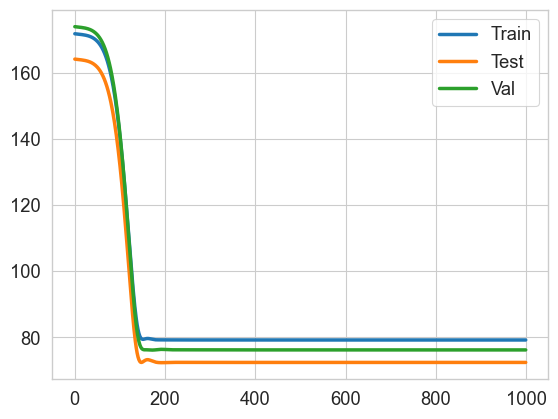

In [193]:
plt.plot(train_losses, label="Train")
plt.plot(test_losses, label="Test")
plt.plot(val_losses, label="Val")
plt.legend()

In [194]:
with torch.no_grad():
    outputs = net(X_test_torch)
    loss = criterion(outputs, y_test_torch)
    print(f"Test loss: {np.sqrt(loss.item())}")
    outputs = net(X_train_torch)    
    loss = criterion(outputs, y_train_torch)
    print(f"Train loss: {np.sqrt(loss.item())}")
    print("")


Test loss: 72.43400147936396
Train loss: 79.22501516152427



In [195]:
# At this point it seems our model is worse than RF, Auto model containing Catboost etc. Let us optimize our NN
# I will use Ray Tune to optimize the hyperparameters

import ray
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

def train_mlp(config):
    net = Net(config["l1"], config["l2"], config["l3"], config["l2_reg"])
    
    criterion = nn.MSELoss()
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
        optimizer.zero_grad()
        outputs = net(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        # Add l2 regularization to loss
        l2_reg = torch.tensor(0.)
        for param in net.parameters():
            l2_reg += torch.norm(param)
        loss += config["l2_reg"] * l2_reg
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        outputs = net(X_val_torch)
        loss = criterion(outputs, y_val_torch)
        return {"loss":np.sqrt(loss.item())}



In [196]:
ray.shutdown()

ray.init()
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=100,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    parameter_columns=["l1", "l2", "l3", "lr", "l2_reg"],
    metric_columns=["loss", "training_iteration"])

analysis = tune.run(
    train_mlp,
    resources_per_trial={"cpu": 1},
    config={
        "l1": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l2": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l3": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l2_reg": tune.loguniform(1e-4, 1.0),
        "lr": tune.loguniform(1e-4, 1.0),
    },
    num_samples=50,
    scheduler=scheduler,
    progress_reporter=reporter)



Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mlp_022eb_00000,2023-02-25_12-15-41,True,,ff29440033cc4bfd825d3d59aad1aef8,"0_l1=256,l2=4,l2_reg=0.0001,l3=128,lr=0.5046",Nipuns-iMac-8.local,1,76.2163,127.0.0.1,34598,3.5459,3.5459,3.5459,1677307541,0,,1,022eb_00000,0.00219083
train_mlp_022eb_00001,2023-02-25_12-15-47,True,,63eada87a43b4914a8971430ac7a0ae4,,Nipuns-iMac-8.local,1,76.2173,127.0.0.1,34605,4.65092,4.65092,4.65092,1677307547,0,,1,022eb_00001,0.00549603
train_mlp_022eb_00002,2023-02-25_12-15-53,True,,be342499a56d424e820441d390343ba1,,Nipuns-iMac-8.local,1,118.73,127.0.0.1,34606,10.5146,10.5146,10.5146,1677307553,0,,1,022eb_00002,0.0124581
train_mlp_022eb_00003,2023-02-25_12-15-47,True,,32614ebe235b493d967dace8955adf86,,Nipuns-iMac-8.local,1,76.3462,127.0.0.1,34607,4.66342,4.66342,4.66342,1677307547,0,,1,022eb_00003,0.004287
train_mlp_022eb_00004,2023-02-25_12-15-52,True,,8b1a3fba98cb421eae151f7f9d7cf5f4,,Nipuns-iMac-8.local,1,76.2167,127.0.0.1,34608,9.10662,9.10662,9.10662,1677307552,0,,1,022eb_00004,0.00521398
train_mlp_022eb_00005,2023-02-25_12-15-54,True,,7e185b7e77454e12bff7ab30b25ee131,"5_l1=32,l2=128,l2_reg=0.0310,l3=256,lr=0.0027",Nipuns-iMac-8.local,1,76.2164,127.0.0.1,34609,10.8734,10.8734,10.8734,1677307554,0,,1,022eb_00005,0.00641322
train_mlp_022eb_00006,2023-02-25_12-15-47,True,,6d9a53982fa947aa8dc7b9602928d696,,Nipuns-iMac-8.local,1,76.2163,127.0.0.1,34610,3.90882,3.90882,3.90882,1677307547,0,,1,022eb_00006,0.00568509
train_mlp_022eb_00007,2023-02-25_12-15-50,True,,f109561c8c214d5baf7ebdc5c8438549,"7_l1=128,l2=2,l2_reg=0.0084,l3=256,lr=0.0284",Nipuns-iMac-8.local,1,76.2163,127.0.0.1,34611,7.11561,7.11561,7.11561,1677307550,0,,1,022eb_00007,0.00779104
train_mlp_022eb_00008,2023-02-25_12-15-47,True,,5eab35cad2a149779160edbf74bef7c6,"8_l1=64,l2=16,l2_reg=0.2049,l3=16,lr=0.0257",Nipuns-iMac-8.local,1,76.2157,127.0.0.1,34612,4.49541,4.49541,4.49541,1677307547,0,,1,022eb_00008,0.0108716
train_mlp_022eb_00009,2023-02-25_12-15-49,True,,d5a685eb63164f8192d88c2396c30494,"9_l1=128,l2=32,l2_reg=0.5183,l3=128,lr=0.7038",Nipuns-iMac-8.local,1,76.2165,127.0.0.1,34613,6.53159,6.53159,6.53159,1677307549,0,,1,022eb_00009,0.00568891


2023-02-25 12:16:05,977	INFO tune.py:762 -- Total run time: 29.90 seconds (29.63 seconds for the tuning loop).


In [199]:
# Print the table for all the trials
df = analysis.results_df

# Sort the table by loss
df.sort_values(by="loss", inplace=True)

# Show only loss, config/l1, config/l2, config/l3, config/lr, training_iteration
df[["loss", "config/l1", "config/l2", "config/l3", "config/lr", "config/l2_reg"]]

,loss,config/l1,config/l2,config/l3,config/lr,config/l2_reg
trial_id,,,,,,
022eb_00043,76.214035,256,16,128,0.081477,0.285665
022eb_00048,76.214599,32,256,32,0.018255,0.332373
022eb_00030,76.215553,256,256,128,0.017494,0.000987
022eb_00008,76.215733,64,16,16,0.025726,0.204854
022eb_00045,76.215774,128,128,32,0.005260,0.000576
022eb_00025,76.216111,256,2,64,0.135036,0.110852
022eb_00049,76.216258,16,128,256,0.073099,0.000124
022eb_00010,76.216284,128,256,32,0.200236,0.000283
022eb_00000,76.216300,256,4,128,0.504588,0.000116


In [200]:
# Print the best hyperparameters

analysis.get_best_config(metric="loss", mode="min")

{'l1': 256,
 'l2': 16,
 'l3': 128,
 'l2_reg': 0.2856648938298237,
 'lr': 0.0814766185989307}

In [201]:
# Perform the final test on the test set

best_config = analysis.get_best_config(metric="loss", mode="min")

# Use the best hyperparameters to train the model
net = Net(best_config["l1"], best_config["l2"], best_config["l3"], best_config["l2_reg"])
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=best_config["lr"])
for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)

    
    loss.backward()
    optimizer.step()

with torch.no_grad():
    outputs = net(X_test_torch)
    loss = criterion(outputs, y_test_torch)
    print(f"Test loss: {np.sqrt(loss.item())}")
    outputs = net(X_train_torch)    
    loss = criterion(outputs, y_train_torch)
    print(f"Train loss: {np.sqrt(loss.item())}")
    print("")
    

Test loss: 72.42421955482158
Train loss: 79.22512301781235



In [207]:
# Thus far it seems even with hyperparameter tuning we are unable to match the performance of ensemble models. 

# Get the top 5 configurations

df[['loss', 'config/l1', 'config/l2', 'config/l3', 'config/lr', 'config/l2_reg']].head(5)


,loss,config/l1,config/l2,config/l3,config/lr,config/l2_reg
trial_id,,,,,,
022eb_00043,76.214035,256,16,128,0.081477,0.285665
022eb_00048,76.214599,32,256,32,0.018255,0.332373
022eb_00030,76.215553,256,256,128,0.017494,0.000987
022eb_00008,76.215733,64,16,16,0.025726,0.204854
022eb_00045,76.215774,128,128,32,0.005260,0.000576


In [208]:
config_list_of_dicts = df[['config/l1', 'config/l2', 'config/l3', 'config/lr', 'config/l2_reg']].head(5).to_dict('records')

# Train an ensemble of 5 models using the top 5 configurations

ensemble = []
for config in config_list_of_dicts:
    net = Net(config["config/l1"], config["config/l2"], config["config/l3"], config["config/l2_reg"])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["config/lr"])
    for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
        optimizer.zero_grad()
        outputs = net(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        # Add L2 regularization
        for param in net.parameters():
            loss += net.l2_reg * torch.norm(param)
        loss.backward()
        optimizer.step()
    ensemble.append(net)


In [209]:
# Get the predictions from the ensemble

ensemble_preds = []
for net in ensemble:
    with torch.no_grad():
        outputs = net(X_test_torch)
        ensemble_preds.append(outputs.numpy())
    
ensemble_preds = np.array(ensemble_preds)

# Get the mean of the predictions

ensemble_preds_mean = ensemble_preds.mean(axis=0)

# Get the RMSE of the ensemble

criterion = nn.MSELoss()
loss = criterion(torch.tensor(ensemble_preds_mean), y_test_torch)
print(f"Test loss: {np.sqrt(loss.item())}")


Test loss: 72.41963824755167


In [349]:
# Do feature selection using sklearn's RFE

from sklearn.feature_selection import RFE

# Create the RFE object and rank each dimension
estimator = RandomForestRegressor()
selector = RFE(estimator, n_features_to_select=5, step=1)

selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[selector.support_]

# Train the RF model on the selected features

rf = RandomForestRegressor()
rf.fit(X_train[selected_features], y_train)

# Get the predictions from the RF model

rf_preds = rf.predict(X_test[selected_features])

# Get the RMSE of the RF model

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds))}")

Test loss: 67.0533416208508


In [350]:
hyperparameters = {"n_estimators": [10, 100, 1000], "max_depth": [1, 5, 10]}


grid_search = GridSearchCV(rf, hyperparameters, cv=5, scoring="neg_root_mean_squared_error")
grid_search.fit(X_valid[selected_features], y_valid)

grid_search.best_params_


{'max_depth': 5, 'n_estimators': 100}

In [351]:
#  Perform the RF with reduced features and hyperparameter tuning on the test set

rf = RandomForestRegressor(**grid_search.best_params_)

# Train on train + valid
rf.fit(pd.concat([X_train[selected_features], X_valid[selected_features]]), pd.concat([y_train, y_valid]))

# Get the predictions from the RF model

rf_preds = rf.predict(X_test[selected_features])

# Get the RMSE of the RF model

print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, rf_preds))}")


Test RMSE: 61.94186395244681


In [354]:
# Use the selected features to train the MLP

X_train_torch = torch.tensor(X_train[selected_features].values, dtype=torch.float32)
y_train_torch = torch.tensor(y_train.values, dtype=torch.float32)

X_test_torch = torch.tensor(X_test[selected_features].values, dtype=torch.float32)
y_test_torch = torch.tensor(y_test.values, dtype=torch.float32)

X_val_torch = torch.tensor(X_valid[selected_features].values, dtype=torch.float32)
y_val_torch = torch.tensor(y_valid.values, dtype=torch.float32)

# Define the model

class Net(nn.Module):
    def __init__(self, l1, l2, l3, l2_reg):
        super(Net, self).__init__()
        self.l1 = nn.Linear(5, l1)
        self.l2 = nn.Linear(l1, l2)
        self.l3 = nn.Linear(l2, l3)
        self.l4 = nn.Linear(l3, 1)
        self.l2_reg = l2_reg

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = self.l4(x)
        return x

# Using Ray Tune to tune the hyperparameters

def train_mlp(config):
    net = Net(config["l1"], config["l2"], config["l3"], config["l2_reg"])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config["lr"])
    for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
        optimizer.zero_grad()
        outputs = net(X_train_torch)
        loss = criterion(outputs, y_train_torch)
        # Add L2 regularization
        for param in net.parameters():
            loss += net.l2_reg * torch.norm(param)
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        outputs = net(X_val_torch)
        loss = criterion(outputs, y_val_torch)
        return {"loss": np.sqrt(loss.item())}

# Define the search space

ray.shutdown()

ray.init()
scheduler = ASHAScheduler(
    metric="loss",
    mode="min",
    max_t=100,
    grace_period=1,
    reduction_factor=2)

reporter = CLIReporter(
    parameter_columns=["l1", "l2", "l3", "lr", "l2_reg"],
    metric_columns=["loss", "training_iteration"])

analysis = tune.run(
    train_mlp,
    resources_per_trial={"cpu": 1},
    config={
        "l1": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l2": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l3": tune.choice([2, 4, 16, 32, 64, 128, 256]),
        "l2_reg": tune.loguniform(1e-4, 1.0),
        "lr": tune.loguniform(1e-4, 1.0),
    },
    num_samples=50,
    scheduler=scheduler,
    progress_reporter=reporter)




Trial name,date,done,episodes_total,experiment_id,experiment_tag,hostname,iterations_since_restore,loss,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_mlp_570ff_00000,2023-02-27_12-08-31,True,,61042389f52a4f4192290e78fc9697c5,"0_l1=16,l2=2,l2_reg=0.0002,l3=4,lr=0.1269",Nipuns-iMac-8.local,1,76.2163,127.0.0.1,74306,2.60175,2.60175,2.60175,1677479911,0,,1,570ff_00000,0.00222492
train_mlp_570ff_00001,2023-02-27_12-08-41,True,,f3012d48617e4755a225b2a4c3692c1e,,Nipuns-iMac-8.local,1,76.2167,127.0.0.1,74311,6.28022,6.28022,6.28022,1677479921,0,,1,570ff_00001,0.0060401
train_mlp_570ff_00002,2023-02-27_12-08-45,True,,eaa456f9515f4591bfc8189893792bac,,Nipuns-iMac-8.local,1,76.9337,127.0.0.1,74312,10.3381,10.3381,10.3381,1677479925,0,,1,570ff_00002,0.00497222
train_mlp_570ff_00003,2023-02-27_12-08-39,True,,87c08568ffae4f818d3089a32147f2f6,"3_l1=128,l2=2,l2_reg=0.0003,l3=64,lr=0.0035",Nipuns-iMac-8.local,1,76.2164,127.0.0.1,74313,5.17509,5.17509,5.17509,1677479919,0,,1,570ff_00003,0.00718617
train_mlp_570ff_00004,2023-02-27_12-08-40,True,,94a0c584588747c4898c019e325f45a2,"4_l1=256,l2=4,l2_reg=0.0002,l3=2,lr=0.7365",Nipuns-iMac-8.local,1,76.2163,127.0.0.1,74314,5.76661,5.76661,5.76661,1677479920,0,,1,570ff_00004,0.00899792
train_mlp_570ff_00005,2023-02-27_12-08-39,True,,64aabf5cafff4035b38edf668105d4e8,,Nipuns-iMac-8.local,1,76.2315,127.0.0.1,74315,4.87173,4.87173,4.87173,1677479919,0,,1,570ff_00005,0.00657916
train_mlp_570ff_00006,2023-02-27_12-08-39,True,,0b1728ef600b4c48bac4b67ce6753125,,Nipuns-iMac-8.local,1,76.2167,127.0.0.1,74316,4.50788,4.50788,4.50788,1677479919,0,,1,570ff_00006,0.00714993
train_mlp_570ff_00007,2023-02-27_12-08-39,True,,a7066079d08f46b2815c68869767ec2e,"7_l1=2,l2=4,l2_reg=0.0206,l3=2,lr=0.3386",Nipuns-iMac-8.local,1,76.2163,127.0.0.1,74317,3.99717,3.99717,3.99717,1677479919,0,,1,570ff_00007,0.00730872
train_mlp_570ff_00008,2023-02-27_12-08-39,True,,70f770eee52d4e0e8c8a4806989cfd67,"8_l1=16,l2=16,l2_reg=0.0001,l3=2,lr=0.0124",Nipuns-iMac-8.local,1,76.2163,127.0.0.1,74318,4.10772,4.10772,4.10772,1677479919,0,,1,570ff_00008,0.00870204
train_mlp_570ff_00009,2023-02-27_12-08-39,True,,d225e237933549cea859f2d9700c686b,"9_l1=32,l2=4,l2_reg=0.0389,l3=64,lr=0.0967",Nipuns-iMac-8.local,1,76.2164,127.0.0.1,74319,4.95295,4.95295,4.95295,1677479919,0,,1,570ff_00009,0.011085


2023-02-27 12:08:56,610	INFO tune.py:762 -- Total run time: 29.94 seconds (29.63 seconds for the tuning loop).


In [359]:
# Get the best hyperparameters

best_config = analysis.get_best_config(metric="loss", mode="min")

# Use the best hyperparameters to train the model
net = Net(best_config["l1"], best_config["l2"], best_config["l3"], best_config["l2_reg"])
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=best_config["lr"])
for epoch in range(1000):  # loop over the dataset multiple times and store the train, test loss
    optimizer.zero_grad()
    outputs = net(X_train_torch)
    loss = criterion(outputs, y_train_torch)
    # Add L2 regularization
    for param in net.parameters():
        loss += net.l2_reg * torch.norm(param)

    
    loss.backward()
    optimizer.step()

with torch.no_grad():
    outputs = net(X_test_torch)
    loss = criterion(outputs, y_test_torch)
    print(f"Test loss: {np.sqrt(loss.item())}")
    outputs = net(X_train_torch)    
    loss = criterion(outputs, y_train_torch)
    print(f"Train loss: {np.sqrt(loss.item())}")
    print("")


Test loss: 72.25798439337863
Train loss: 79.40200082098058



In [360]:
# Building a simple meta-learning model in PyTorch

# Encoder takes in context set (x, y) pairs and outputs a vector representation of the context set

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.tanh(x)
        return x


In [361]:
# Generate context sets and target sets

len_train = len(X_train_torch)
num_context = 10
num_target = 2
context_length = 5

context_idx = np.random.choice(np.arange(0, len_train), num_context, replace=False)
# Set difference to find the target set

target_idx = np.random.choice(np.setdiff1d(np.arange(0, len_train), context_idx), num_target, replace=False)
target_idx, context_idx

(array([232,  30]), array([174,  15, 179,  10,  26, 176, 205, 221, 214,  32]))

In [362]:
# Adding 1 for the "y"
enc = Encoder(X_train_torch.shape[1] + 1, 10, context_length)

In [363]:
X_train_torch[context_idx].shape, y_train_torch[context_idx].shape

(torch.Size([10, 5]), torch.Size([10]))

In [364]:
# Create context set by concatenating the x and y values

context_set = torch.concat((X_train_torch[context_idx], y_train_torch[context_idx].reshape(-1, 1)), axis=1)
enc(context_set).mean(axis=0)

tensor([-1.0000, -0.9639, -1.0000,  1.0000,  0.8432], grad_fn=<MeanBackward1>)

In [365]:
# Decoder takes in the context set vector representation and the target set inputs and outputs the target set predictions

class Decoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.tanh(x)
        return x


In [366]:
dec = Decoder(context_length + X_train_torch.shape[1], 10, 1)

In [367]:
# Repeat the mean of context set for each target set input
enc(context_set).mean(axis=0).repeat(num_target).reshape(num_target, -1).shape, X_train_torch[target_idx].shape


(torch.Size([2, 5]), torch.Size([2, 5]))

In [368]:
# Input to the decoder is the concatenation of the context set vector representation and the target set inputs

dec(torch.concat((enc(context_set).mean(axis=0).repeat(num_target).reshape(num_target, -1), X_train_torch[target_idx]), axis=1))


tensor([[-0.3632],
        [-0.3553]], grad_fn=<TanhBackward0>)

In [398]:
# Tie the encoder and decoder together to create the meta-learning model

class MetaNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, context_length):
        super(MetaNet, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.context_length = context_length
        self.enc = Encoder(self.input_size + 1, self.hidden_size, self.context_length)
        self.dec = Decoder(self.context_length + self.input_size, self.hidden_size, self.output_size)
        
    def forward(self, context_set, target_set):
        context_set = torch.concat((context_set[0], context_set[1].reshape(-1, 1)), axis=1)
        context_set_vec = self.enc(context_set).mean(axis=0).repeat(target_set.shape[0]).reshape(target_set.shape[0], -1)
        return self.dec(torch.concat((context_set_vec, target_set[:, :-1]), axis=1))


In [399]:
# Procedure to obtain the context set and target set

def get_context_target(X, y, num_context, num_target):
    len_train = len(X)
    context_idx = np.random.choice(np.arange(0, len_train), num_context, replace=False)
    target_idx = np.random.choice(np.setdiff1d(np.arange(0, len_train), context_idx), num_target, replace=False)
    return (X[context_idx], y[context_idx]), (X[target_idx], y[target_idx])


In [401]:
context_set, target_set = get_context_target(X_train_torch, y_train_torch, num_context, num_target)

In [402]:
target_set

(tensor([[-0.0382,  0.0046,  0.0356,  0.0163, -0.0011],
         [-0.0382,  0.0671, -0.0608, -0.0015,  0.0196],
         [ 0.0381, -0.0245,  0.0047, -0.0160, -0.0259],
         [ 0.0344,  0.1253,  0.0288,  0.0003,  0.0279],
         [ 0.0417,  0.0121,  0.0391,  0.0456, -0.0011],
         [ 0.0381, -0.0181,  0.0666, -0.0119, -0.0135],
         [ 0.0308, -0.0202, -0.0057, -0.0109, -0.0011],
         [ 0.0126,  0.0337,  0.0333,  0.0312,  0.0279],
         [-0.1000, -0.0676, -0.1090, -0.0499, -0.0094],
         [ 0.0635, -0.0041, -0.0126,  0.0845, -0.0176]]),
 tensor([107.,  78., 200., 341., 235.,  77., 148., 198.,  55., 202.]))

In [400]:
# Training the meta-learning model

num_context = 40
num_target = 10
context_length = 10
num_epochs = 1500


meta_net = MetaNet(X_train_torch.shape[1], 10, 1, context_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(meta_net.parameters(), lr=0.001)

# Store the train, validation and test losses
train_losses = []
val_losses = []
test_losses = []


for epoch in range(num_epochs):
    context_set, target_set = get_context_target(X_train_torch, y_train_torch, num_context, num_target)
    optimizer.zero_grad()
    preds = meta_net(context_set, target_set)
    loss = criterion(preds, target_set[1])
    loss.backward()
    optimizer.step()
    train_losses.append(torch.sqrt(loss).item())
    


AttributeError: 'tuple' object has no attribute 'shape'

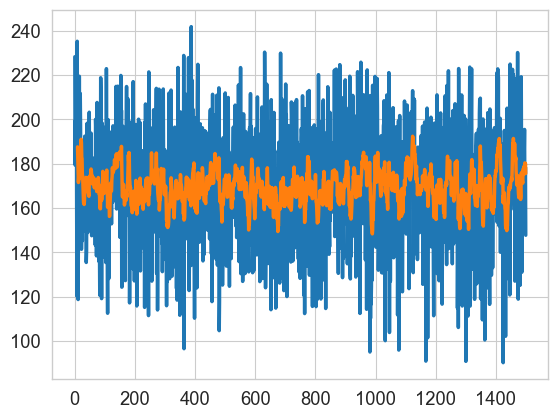

In [383]:
plt.plot(train_losses)
# Smooth the loss curve
plt.plot(pd.Series(train_losses).rolling(10).mean())

In [395]:
# Predict on the test set with the trained meta-learning model and calculate the test loss

# get context set from train set and target set from test set
context_set, ts = get_context_target(X_train_torch, y_train_torch, num_context, len(X_test_torch))
target_set = X_test_torch


In [397]:
ts[1]

tensor([132., 246., 162.,  44., 118.,  71.,  78., 152., 138., 113., 308.,  73.,
         90., 252., 129., 154.,  53., 321., 131., 274., 202., 110.,  71., 178.,
         85., 151.,  85., 150., 275., 341., 192., 303., 246., 273., 182.,  65.,
        126., 272., 150.,  80., 248.,  70., 142.,  64.,  78., 173.,  49.,  53.,
         74., 200., 230., 196.,  72.,  91., 270., 104., 124., 265., 217.,  55.,
        120., 160., 128.,  96.,  72., 111.,  53.,  59.,  81., 243., 264.,  60.,
         87., 295.,  42., 170., 200.,  50.,  49., 113.,  60., 281.,  69., 136.,
        310., 258., 140.,  69.,  53., 153.,  94., 279.,  84., 102., 164., 110.,
        143.,  87., 145., 293., 202., 131., 280., 245.,  58.,  66., 310., 230.,
        257., 163., 103.])

In [394]:
meta_net(context_set, _).shape

torch.Size([111, 1])

In [ ]:
context_set = torch.concat((context_set[0], context_set[1].reshape(-1, 1)), axis=1)
target_set = torch.concat((target_set[0], target_set[1].reshape(-1, 1)), axis=1)
context_set_vec = self.enc(context_set).mean(axis=0).repeat(target_set.shape[0]).reshape(target_set.shape[0], -1)
return self.dec(torch.concat((context_set_vec, target_set[:, :-1]), axis=1))
